## Based on https://www.kaggle.com/christianwallenwein/fastest-way-to-crop-all-images

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import cv2
from IPython.display import Image

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm as tqdm
from skimage import io, transform

In [7]:
# Load boxes by faster rcnn
test_boxes = pd.read_csv('./detection_output/detected.csv')

unicode_map = {codepoint: char for codepoint, char in pd.read_csv('./input/unicode_translation.csv').values}
unicode_vocab = sorted(list(unicode_map))
unicode2id = {codepoint: i for (i, codepoint) in enumerate(unicode_vocab)}

print(test_boxes.shape)
test_boxes.head()

(4150, 2)


,labels,image_id
0,seg_fp 201 558 122 124 seg_fp 1793 1926 125 12...,test_00145af3
1,seg_fp 1132 1693 91 124 seg_fp 1456 1619 96 10...,test_001c37e2
2,seg_fp 628 2130 90 93 seg_fp 1434 2445 80 78 s...,test_003aa33a
3,seg_fp 876 1759 100 117 seg_fp 161 1949 84 134...,test_00665e33
4,seg_fp 1693 2511 117 131 seg_fp 254 2667 96 10...,test_006964dc


In [10]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.5):
    '''
        NMS for reduce boxes (currently not used)
    '''
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int"), pick

In [21]:
def cropImage(boxes, loop1_index):
    '''
    Preview cropped images
    '''
    
    if isinstance(boxes, float):
        return None

    filepath = './input/test_images/{}.jpg'.format(row.image_id)
    
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = boxes.split(" ")

    # to get the highest speed, we use numpy for the cropping of the images
    # numpy doesn't support strings in their ndarrays
    # that's why we move unicodes outside of labels
    unicode = boxes[::5]
    del boxes[::5]
    

    boxes = np.array(boxes, dtype=np.int16)

    boxes = boxes.reshape(-1, 4)

    boxes[:, 2] = np.sum(a=boxes[:,[0,2]], axis=1)
    boxes[:, 3] = np.sum(a=boxes[:,[1,3]], axis=1)

    return [img[label[1]:label[3], label[0]:label[2]] for loop2_index, label in enumerate(boxes)]

In [26]:
for loop1_index, (list_index, row) in tqdm(enumerate(test_boxes[:1].iterrows())):
    temp = cropImage(row.boxes, loop1_index)

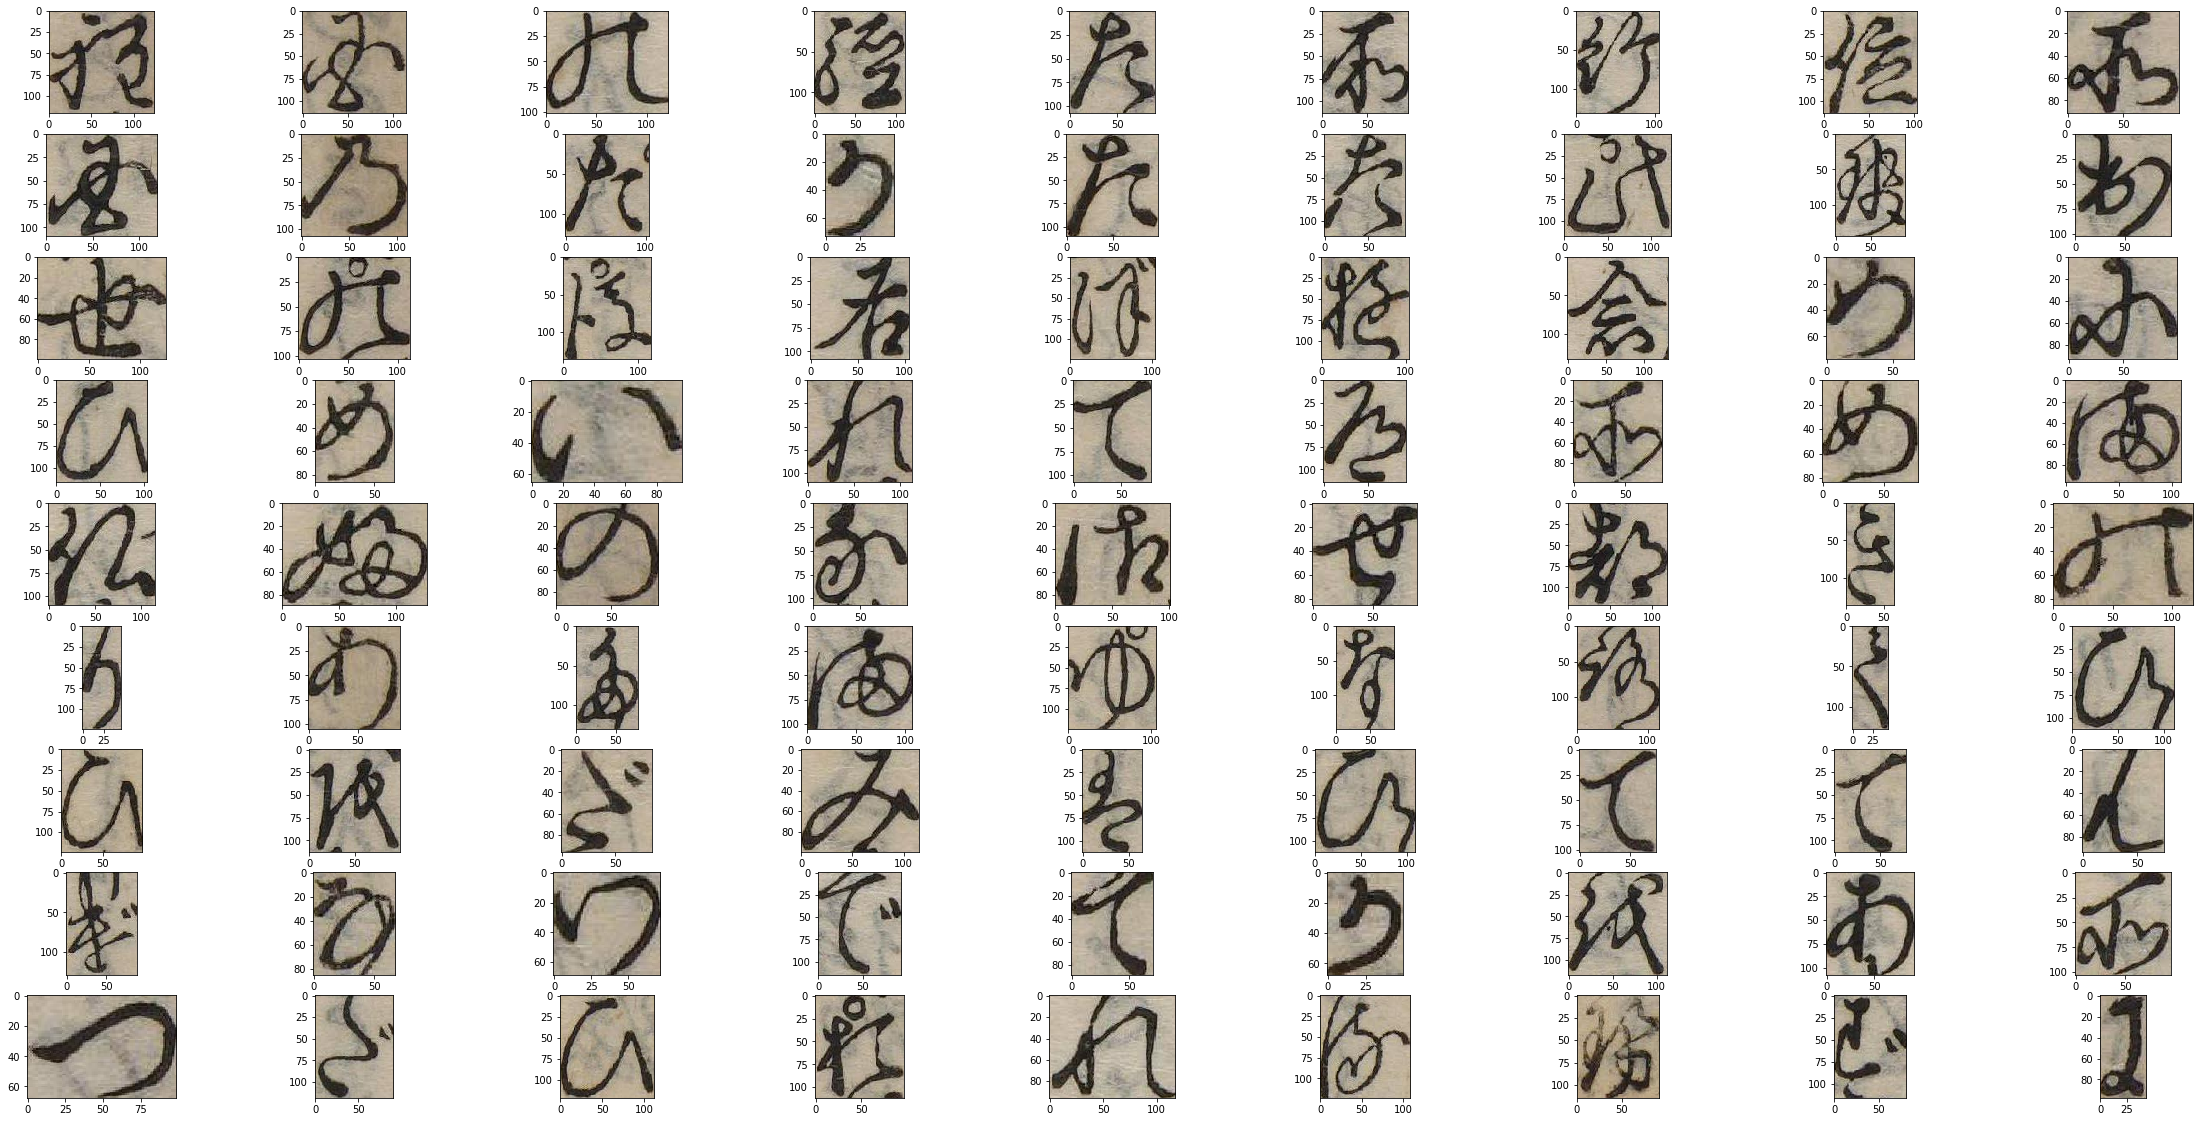

In [27]:
rows = 9
columns = 9
fig = plt.figure(figsize=(40, 20))

for i in range(1, rows*columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(temp[i], aspect='equal')

In [28]:
def crop_and_save(boxes, loop1_index):
    '''
        Save cropped images into the structure below
        
        cropped
        ├── image_id
        │       ├── centery_centerx.jpg (ex: 120.5_35.5.jpg)
    '''
    error_counter = 0
    if isinstance(boxes, float):
        return None

    filepath = './input/test_images/{}.jpg'.format(row.image_id)
    
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    boxes = boxes.split(" ")

    unicode = boxes[::5]
    del boxes[::5]

    boxes = np.array(boxes, dtype=np.int16)
    boxes = boxes.reshape(-1, 4)
    centers_x = boxes[:, 0] + boxes[:, 2] * 0.5
    centers_y = boxes[:, 1] + boxes[:, 3] * 0.5
    
    boxes[:, 2] = np.sum(a=boxes[:,[0,2]], axis=1)
    boxes[:, 3] = np.sum(a=boxes[:,[1,3]], axis=1)
    
    #boxes, pick = non_max_suppression_fast(boxes, 0.5)
    #centers = centers[pick] 
    
    if not os.path.exists('./cropped'):
        os.mkdir('./cropped')
    if not os.path.exists('./cropped/{}'.format(row.image_id)):
        os.mkdir('./cropped/{}'.format(row.image_id))
    
    for loop2_index, label in enumerate(boxes):
        try:
            Image.fromarray(img[label[1]:label[3], label[0]:label[2]]).save('./cropped/{}/{}_{}.jpg'.format(row.image_id, centers_x[loop2_index], centers_y[loop2_index]))
        except Exception as e:
            error_counter += 1
    return error_counter

## For Windows

In [30]:
# For windows
pbar = tqdm(total=len(test_boxes))
for loop1_index, (list_index, row) in enumerate(test_boxes.iterrows()):
    crop_and_save(row.labels, loop1_index)
    pbar.update(1)
pbar.close()

## For linux

In [ ]:
# from multiprocessing import Process, current_process

# processes = []

# pbar = tqdm(total=len(test_boxes))
# for loop1_index, (list_index, row) in enumerate(test_boxes.iterrows()):
#     process = Process(target=crop_and_save, args=(row.boxes, loop1_index))
#     pbar.update(1)
#     processes.append(process)
    
#     process.start()
# pbar.close()

## Save zip

In [ ]:
# import shutil
# shutil.make_archive("cropped", "zip", './cropped')